# RSNA Intracranial Hemorrhage Detection EDA

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

import os
import cv2
from os import listdir


## 1. Reading the data

In [2]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"

In [3]:
testdf = pd.read_csv(INPUT_PATH + 'stage_2_sample_submission.csv')
traindf = pd.read_csv(INPUT_PATH + 'stage_2_train.csv')
train_images = listdir(INPUT_PATH + 'stage_2_train')
test_images = listdir(INPUT_PATH + 'stage_2_test')

In [4]:
traindf.head(15)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


For each image, we have 6 rows. First 5 rows for each image represent the subtype of brain hemorrhage. The 6th row is to show probability of presence of 'any' type of brain hemorrhage. The column 'Label' contains the corresponding probability values. The column 'ID' contains the image id name and also the hemorrhage subtype name. For better data analysis, this can be split into two columns of 'ID' and 'Subtype'

In [5]:
labels = traindf.Label
traindf = traindf.ID.str.rsplit(pat = '_', n = 1, expand = True)
traindf.loc[:,'Label'] = labels.values
traindf = traindf.rename({0:'ID', 1: 'Subtype'}, axis = 1)

In [6]:
traindf.head()

,ID,Subtype,Label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


Do the same for test data also. In the test data, we need to predict the labels. The already included label values are 0.5. Replace them with 0 for the time being.

In [7]:
testdf.head()

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5


In [8]:
testdf = testdf.ID.str.rsplit(pat = '_', n = 1, expand = True)
testdf = testdf.rename({0:'ID', 1: 'Subtype'}, axis = 1)
testdf.loc[:, 'Label'] = 0
testdf.head()

,ID,Subtype,Label
0,ID_0fbf6a978,epidural,0
1,ID_0fbf6a978,intraparenchymal,0
2,ID_0fbf6a978,intraventricular,0
3,ID_0fbf6a978,subarachnoid,0
4,ID_0fbf6a978,subdural,0


In [9]:
total_train_im = traindf.ID.nunique()
total_test_im = testdf.ID.nunique()
print("train image unique ids in dataframe: {}\n".format(total_train_im))
print("test image unique ids in dataframe: {}\n".format(total_test_im))

train image unique ids in dataframe: 752803

test image unique ids in dataframe: 121232



In [10]:
# now conforming from the number of image files we have as training and test data.
print('Total train images: {}\n'.format(len(train_images)))
print('Total test images: {}\n'.format(len(test_images)))

Total train images: 752803

Total test images: 121232



## 2. Visual Analysis

### 2.1. Visualizing Positive (1) / Negative (0) labels

Text(0.5, 1.0, 'How often positive examples occur')

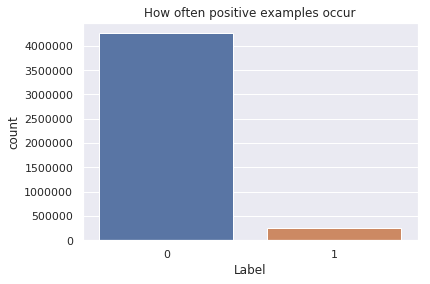

In [11]:
sns.countplot(traindf.Label)
plt.title('How often positive examples occur')

### 2.2. Visualizing Multilabels  
Each image can also have positive label (1) for more than one class. 

In [12]:
# unique Lables
traindf.Label.unique()

array([0, 1])

so Label is either 0 or 1 in training data. We can do the following to find the number of positive classes (classes having label 1) for a given image.


Text(0, 0.5, 'No. of images')

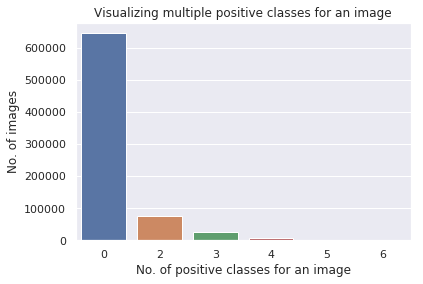

In [13]:
multi_class_counts = traindf.groupby('ID').Label.sum()
sns.countplot(multi_class_counts)
plt.xlabel("No. of positive classes for an image")
plt.title("Visualizing multiple positive classes for an image")
plt.ylabel('No. of images')


### 2.3. Positive Occurence of Subtypes of Hemorrhage  
We can visualize how much the percentage of each subtype with positive (1) label value is.

Text(0.5, 1.0, 'Positive occurences of hemorrhage subtypes')

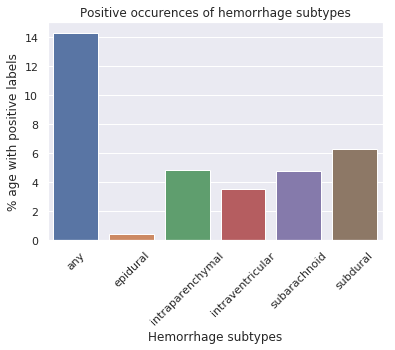

In [14]:
pos_subtype_percent = ( traindf.groupby("Subtype").Label.sum()/total_train_im )*100
sns.barplot(x = pos_subtype_percent.index, y = pos_subtype_percent.values)
plt.xticks(rotation = 45)
plt.ylabel('% age with positive labels')
plt.xlabel("Hemorrhage subtypes")
plt.title("Positive occurences of hemorrhage subtypes")

### 2.4. Observations

- The above plots show that we have high class imbalance between positive and negative occurences.
- Each image can have at least 2 or no positive y labels. So you will not see an image having only one positive target label. This is because we have a class named 'any'. If an image is diagnosed with any particular subtype of hemorrhage, both the 'any' class and that particular hemorrhage subtype will be labelled as 1.
- The subtype 'epidural' is very critical becuase it has only a few positive occurences.

## 3. DICOM Files  
DICOM (Digital Imaging and Communications in Medicine) is a well-known format used in the medical field to record and tranfer different medical diagnoses (e.g. CT scans). Each DICOM file contains the information about the pixel data of an image and some other relevant information (e.g. patient ID) in the form of metadata.   

Let's read a dcm file.

In [15]:
dcm_data = pydicom.dcmread(INPUT_PATH + 'stage_2_train/' + train_images[1])
print(dcm_data)

(0008, 0018) SOP Instance UID                    UI: ID_b313578bd
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_dfe0eb92'
(0020, 000d) Study Instance UID                  UI: ID_bc2ba71c46
(0020, 000e) Series Instance UID                 UI: ID_d966338234
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-4', '387.800049']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) High Bit  

The DICOM files in this project consist of the CT scan images, where the pixel values at different locations are linked to radiointensity (Hounsfield Units HU). These HU units are visualized as grey scale values ranging between -1000 and +1000. Different tissues are shown with different HU values. Bones have HU value very close to 1000, while air has HU value of -1000. The problem is that the human eye cannot identify so many variations in the grey scale. Therefore, we use the concept of window, where we visualize the grey scale values just in the range of a user (doctor) defined window width. The HU value at the centre of a window is called "Level" of that window.  

Different types of windows are used in the medical field. It depends upon what you want to visualize in a CT scan.

### 3.1. Distribution of Raw and Rescaled Pixel Values  
The raw pixel values recorded in the DICOM data are not HU values. In fact, we need to apply linear transformation on the raw pixel values to get the HU values. For that, the slope and intercept are given in the metadata of each dcm file.

Text(0.5, 1.0, 'HU unit distributions for 10 examples')

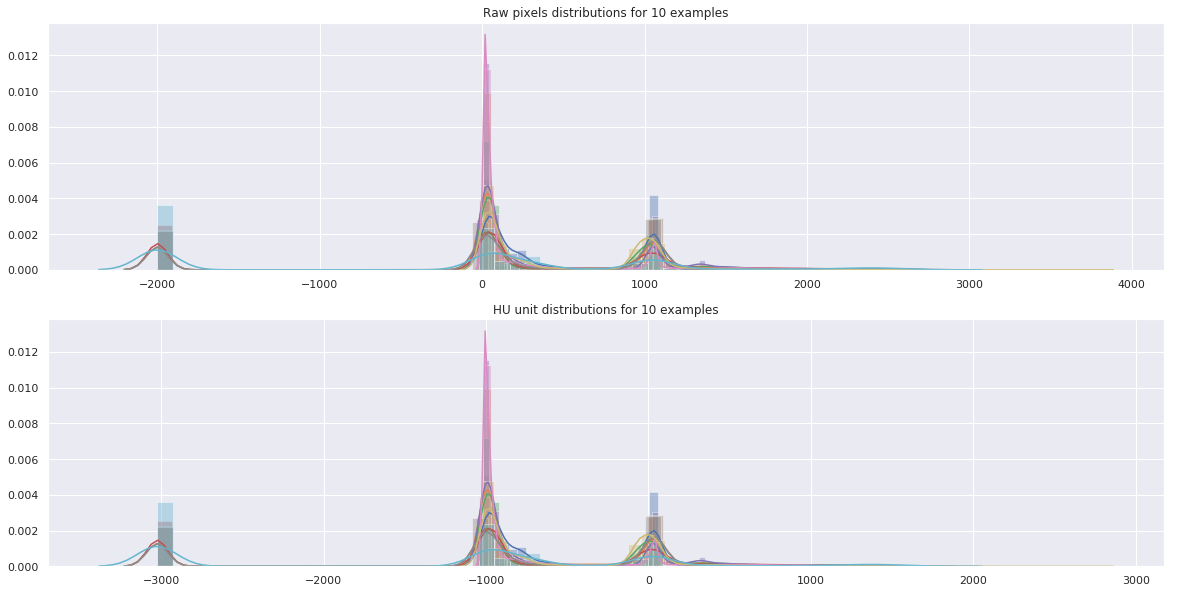

In [16]:
fig, axes = plt.subplots(2, 1, figsize = (20, 10))

# let's visualize the distribution of raw and rescaled pixels of first 10 images

for im in range (10):
    file_name = train_images[im]
    dcm_data = pydicom.dcmread(INPUT_PATH + 'stage_2_train/' + file_name)
    raw_pixels = dcm_data.pixel_array.flatten()
    rescaled_pixels = raw_pixels * dcm_data.RescaleSlope + dcm_data.RescaleIntercept
    
    sns.distplot(raw_pixels, ax = axes[0])
    sns.distplot(rescaled_pixels, ax = axes[1])
    
axes[0].set_title('Raw pixels distributions for 10 examples')
axes[1].set_title("HU unit distributions for 10 examples")

As explained earlier, the HU values range between -1000 and 1000, but here we also see peaks at -2000 and -3000. These are common in the CT scans and they represent the background air. So, they can be replaced with -1000.

Let's say, W is window width and L is level, then the following 5 windows are commonly used by the radiologists:
1. Brain Matter window : W:80 L:40  
2. Blood/subdural window: W:130-300 L:50-100
3. Soft tissue window: W:350–400 L:20–60
4. Bone window: W:2800 L:600
5. Grey-white differentiation window: W:8 L:32 or W:40 L:40

### 3.2. DICOM Helper Functions

In [17]:
def rescale_image(dcm):
    """
    Applies the linear transformation to get the Hounsfield Unit (HU) values from the pixel values.
    
    Parameters
    ----------
    dcm : DICOM data set

    Returns
    -------
    rescaled_pixels : numpy array
        rescaled image pixel after applying the linear transformation.
    
    """    
    
    
    pixels = dcm.pixel_array
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope    
    rescaled_pixels = slope * pixels + intercept
    
    return rescaled_pixels
    

def window_image(dcm, window_center, window_width, normalize = True):
    """
    Applies a window of user specified width and center to DICOM image. 
    
    Parameters
    ----------
    dcm : DICOM data set
    window_center : int
    window_width : int
    normalize : bool, optional
        Normalizes the pixel values between 0 and 1. Default is True.

    Returns
    -------
    rescaled_pixels : numpy array
        rescaled image pixel after applying the specified window. This can now be plotted for visualization.
    
    """
    

    # apply linear transformation
    rescaled_pixels = rescale_image(dcm)
    
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    
    # apply the specified window
    rescaled_pixels[rescaled_pixels < img_min] = img_min
    rescaled_pixels[rescaled_pixels > img_max] = img_max
    
    if normalize:
        # normalizing to 0-1
        rescaled_pixels = (rescaled_pixels - img_min) / (img_max - img_min)
    
    return rescaled_pixels

def get_first_int(x):
    """
    Single valued quantities (e.g. window width, center), may be recorded as a list where the value 
    is repeated multiple times. This function returns the first entry.
    
    """
    
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_doctor_window(dcm):
    """
    Returns the window width and level which is included in the metadata of DICOM of an image.
    
    Parameters
    ----------
    dcm : DICOM data
 
    Returns
    -------
    dicom_fields : python list
        dicom_fields = [window_center, window_width] 
        
    """
    dicom_fields = [dcm.WindowCenter, dcm.WindowWidth]
    
    dicom_fields = [get_first_int(x) for x in dicom_fields]
    
    return dicom_fields


def doctor_window (dcm, normalize = True):
    """
    Applies the doctor window with window width and center specified inside the metadata of DICOM file.
    
    Parameters
    ----------
    dcm : DICOM data set
    normalize : bool, optional
        Normalizes the pixel values between 0 and 1. Default is True.

    Returns
    -------
    rescaled_pixels : numpy array
        rescaled image pixel after applying the doctor window. This can now be plotted for visualization.
    
    """

    # apply linear transformation
    rescaled_pixels = rescale_image(dcm)
    
    # get the doctor window parameters
    window_center, window_width = get_doctor_window(dcm)
    
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    
    # apply the doctor window
    rescaled_pixels[rescaled_pixels < img_min] = img_min
    rescaled_pixels[rescaled_pixels > img_max] = img_max
    
    if normalize:
        # normalize to 0-1
        rescaled_pixels = (rescaled_pixels - img_min) / (img_max - img_min)
    
    return rescaled_pixels



def bsb_window(dcm):
    
    
    """
    Applies brain, subdural and soft windows to the image. All three windowed
    images are stacked together to make RGB image.

    Parameters
    ----------
    dcm: dcm data set

    Returns
    -------
    bsb_img : numpy array
        numpy array with pixel values corresponding to brain, subdural and 
        soft windowed images.

    """
    
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img
    

    
def view_images(dcm_file, axes, window = 'doctor'):
    """
    Function to visualize the brain CT scan.
    """

    dcm = pydicom.dcmread(dcm_file)
    
    if window == 'doctor':
        image = doctor_window(dcm)
    elif window == 'bsb':
        image = bsb_window(dcm)
    elif window == None:
        image = dcm.pixel_array
    
    axes.imshow(image, cmap=plt.cm.bone) 
    axes.axis('off')


Text(0.5, 0.98, 'First 10 examples without applying any windows')

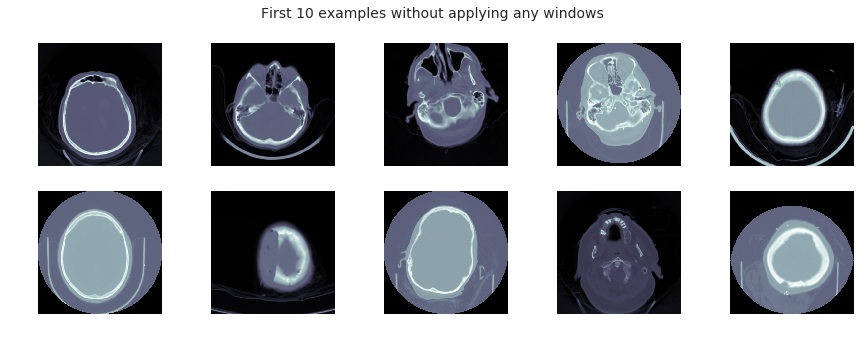

In [18]:
# visualizing first 10 scans without applying any windows

fig, axes = plt.subplots(2, 5 , figsize = (15, 5))
images = [INPUT_PATH + 'stage_2_train/' + im for im in train_images[:10]]

im_no = 0
for row in range(2):
    for col in range(5):
        dcm_file = images[im_no]
        view_images(dcm_file, axes[row, col], window = None)
        im_no += 1
fig.suptitle("First 10 examples without applying any windows", fontsize=14)

From above scans, it is difficult to get the information about brain hemorrhage. Now, we observe the effect of window application.

Text(0.5, 0.98, 'First 10 examples after applying doctor windows')

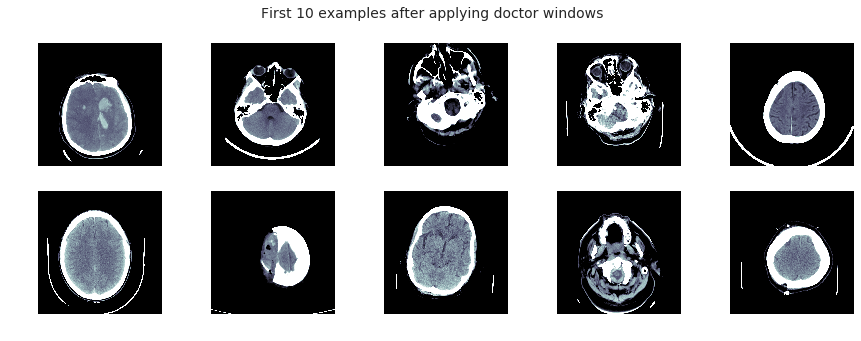

In [19]:
# visualizing first 10 scans after applying doctor windows

fig, axes = plt.subplots(2, 5 , figsize = (15, 5))
images = [INPUT_PATH + 'stage_2_train/' + im for im in train_images[:10]]

im_no = 0
for row in range(2):
    for col in range(5):
        dcm_file = images[im_no]
        view_images(dcm_file, axes[row, col], window= 'doctor')
        im_no += 1
fig.suptitle("First 10 examples after applying doctor windows", fontsize=14)

Text(0.5, 0.98, 'First 10 examples after applying bsb windows')

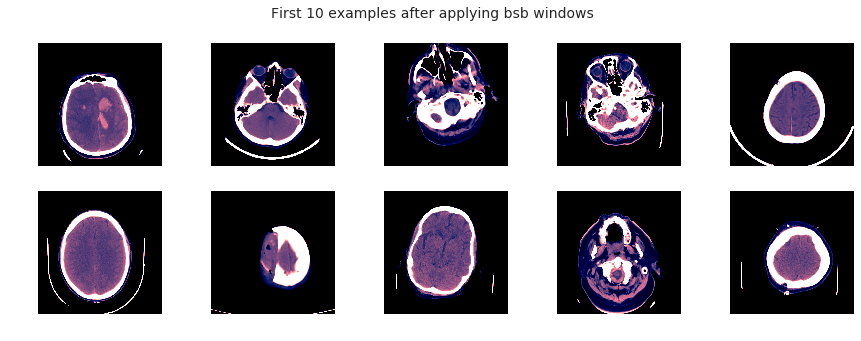

In [20]:
# visualizing first 10 scans after applying bsb windows

fig, axes = plt.subplots(2, 5 , figsize = (15, 5))
images = [INPUT_PATH + 'stage_2_train/' + im for im in train_images[:10]]

im_no = 0
for row in range(2):
    for col in range(5):
        dcm_file = images[im_no]
        view_images(dcm_file, axes[row, col], window= 'bsb')
        im_no += 1
fig.suptitle("First 10 examples after applying bsb windows", fontsize=14)

Now, these images after applying bsb window can be regarded as RGB image. This can now be fed to deep learning model after converting into appropriate size. The default size of the images included in the DICOM files is 512 by 512 pixels.

## 4. Data Preparation  
In order to feed the training data to model, we need to do some preprocessing. We need to convert the Labels into one-hot-encoding. Each subtype of hemorrhage will have a separate column.

In [21]:
traindf = pd.pivot_table(traindf, index="ID", columns="Subtype", values="Label")
traindf.head(10)

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0
ID_0000ca2f6,0,0,0,0,0,0
ID_0000f1657,0,0,0,0,0,0
ID_000178e76,0,0,0,0,0,0


In [23]:
testdf = pd.pivot_table(testdf, index="ID", columns="Subtype", values="Label")
testdf.head(10)

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ID,,,,,,
ID_000000e27,0,0,0,0,0,0
ID_000009146,0,0,0,0,0,0
ID_00007b8cb,0,0,0,0,0,0
ID_000134952,0,0,0,0,0,0
ID_000176f2a,0,0,0,0,0,0
ID_0001af484,0,0,0,0,0,0
ID_0001f6d2a,0,0,0,0,0,0
ID_000210e16,0,0,0,0,0,0
ID_0002bd10a,0,0,0,0,0,0


## 5. Conclusion 
Now, the modelling part can be started. The points to keep in mind from the Exploratory Data Analysis (EDA) are:
1. The training data has high class imbalance. Use appropriate loss function (e.g. Focal Loss).
2. Apply appropriate windows in the preprocessing step and stack them together to generate an RGB image. This might require to write a custom data preprocessor and data loader.
3. Don't forget to resize the images according to the input shape requirement of the model selected for transfer learning.